# 오차역전파법 (Back Propagation)

## 역전파법 개념

가중치 매개변수를 갱신하기 위한 기울기를 효율적으로 계산하는 방법.

수치미분과 비교해보면 수치미분은 단순하고 구현하기 쉽지만 계산에 오랜 시간이 걸리는 단점을 갖고 있다.

오차역전파법을 계산그래프로 설명하는 방법은 안드레 카패시(Andrej Karpathy)의 블로그 및 그와 함께한 페이페이 리(Fei-Fei Li) 교수가 진행한 스탠퍼드 대학교 딥러닝 수업 CS231n에서 나왔으며 본 강의자료의 참고문헌인 '밑바닥부터 시작하는 딥러닝'에서 자세히 확인할 수 있다.

노드와 엣지를 사용하여 역전파를 표현하면 다음과 같이 그릴 수 있다.

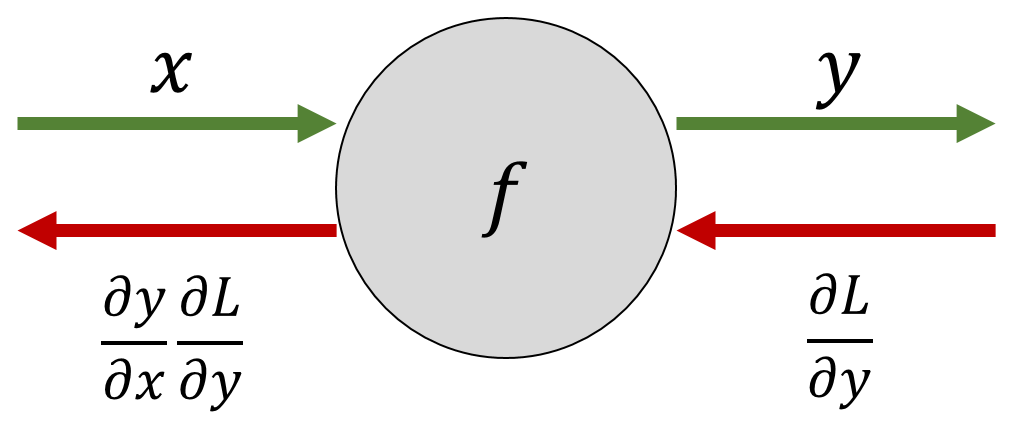

여기서 초록색 선은 순전파이며 붉은색 선은 역전파이다.

즉 역전파는 순전파를 미분한 값이며 노드를 통과한 역전파는 (현재 순전파의 미분값) * (이전 순전파의 미분값)을 갖게 된다.

덧셈 노드의 역전파를 생각해보면 덧셈 노드는 z = x + y 라는 식으로 표현할 수 있고 이를 미분하면,

    dz/dx = 1
    dz/dy = 1
    
이것을 역전파로 표현하면,

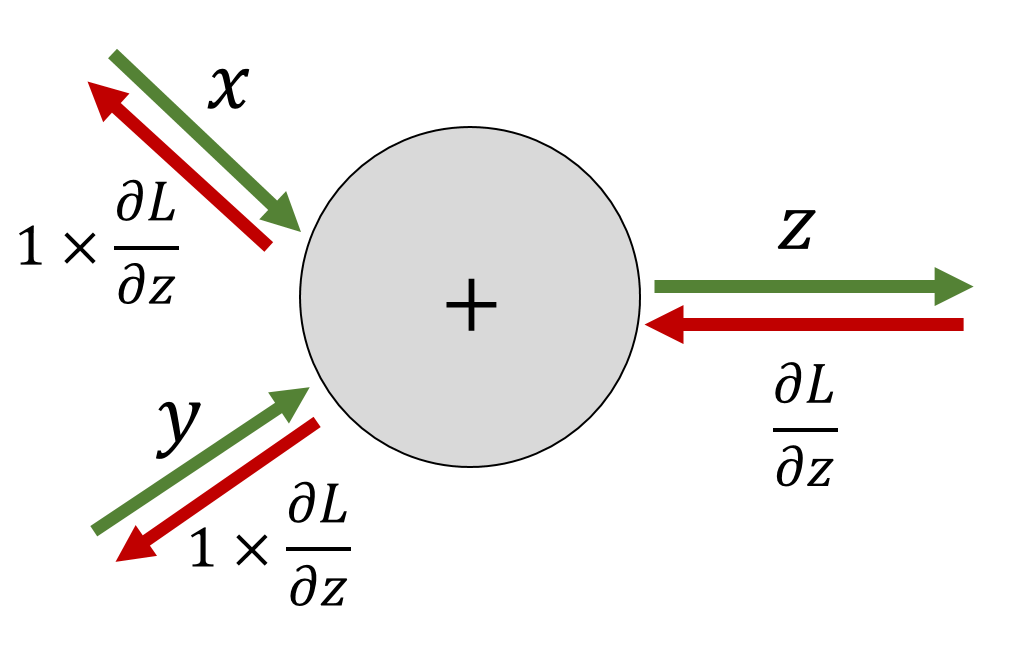

마잔가지로 곱셈 노드는 다음과 같이 표현할 수 있다.

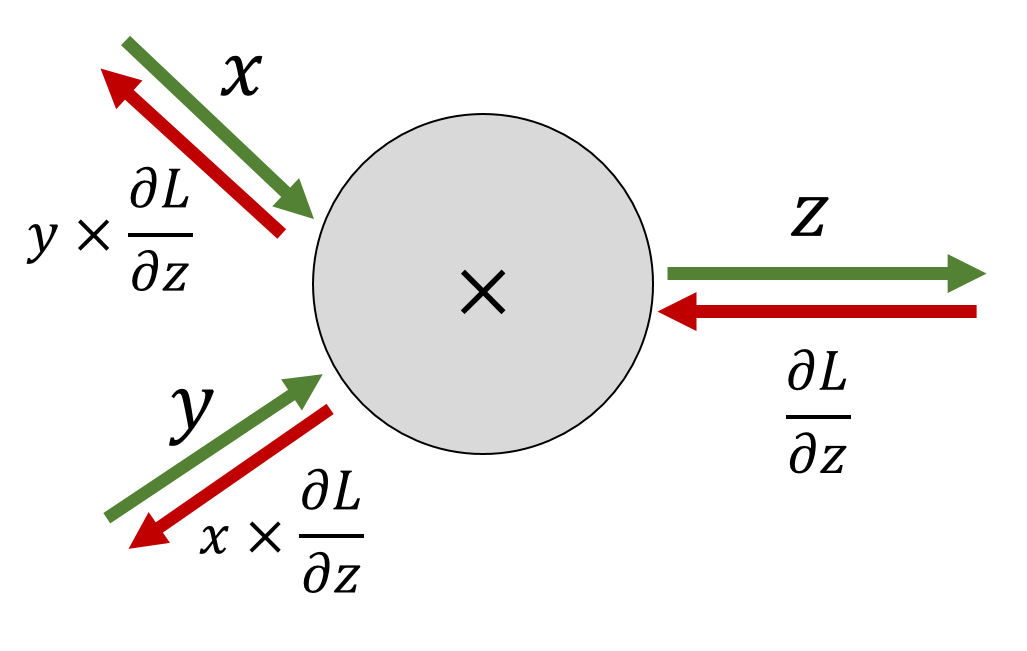

## 노드 구현

노드를 코드로 구현하며 역전파법의 동작 원리를 익힌다.

### 곱셈 노드

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x # self에 값을 저장해둠(backward에서 사용)
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 교환
        dy = dout * self.x
        
        return dx, dy

### MulLayer를 사용하여 사과 구입 예제 구현

In [6]:
apple = 100
apple_num = 2
tax = 1.1

# 계층
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple,apple_num) # 사과값*사과개수
price = mul_tax_layer.forward(apple_price, tax) # 전체 사과값*세금

print(price)

220.00000000000003


### 역전파 미분

In [7]:
dprice = 1 # 초기값
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [8]:
### 덧셈 노드

In [9]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out # 역전파에서 그냥 흘려보내주므로 순전파를 저장하지 않아도 된다.
    
    def backward(self, dout):
        dx = dout * 1 # 그대로 출력되므로 1이 곱해진다
        dy = dout * 1
        return dx, dy

### 사과 2개와 귤 3개를 구입하는 예제

In [10]:
orange = 150
orange_num = 3
# 사과는 위와같다

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple,apple_num) # 사과값*사과개수
orange_price = mul_orange_layer.forward(orange,orange_num) # 사과값*사과개수
add_price = add_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(add_price, tax) # 전체 사과값*세금

dprice = 1 # 초기값
dadd_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_layer.backward(dadd_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 딥러닝 주요 함수 구현

### ReLU 함수의 계층 구현

ReLU 함수는 x의 값이 0보다 작을때는 0을 출력하며 그보다 클때는 값을 그대로 출력한다.

미분하면 x<=0 일때는 0이고 이외는 1이 된다.

In [12]:
class Relu:
    def __init__(self):
        self.mask = None # mask는 0과 1로 구성된 넘파이 배열이다. 입력 x 값이 0이하면 True 그외에는 False를 유지한다.
        
    def forward(self, x):
        self.mask = (x<=0) # 마스크 지정
        out = x.copy() # x값을 카피하여 출력 out으로 사용
        out[self.mask] = 0 # x의 값이 0 아래인(mask 값이 True인) 요소들은 0으로 변경한다.
        
        return out
    
    def bacward(self, dout):
        dout[self.mask] = 0 # x 값이 0 아래일 경우에는 0으로 출력한다.
        dx = dout # 나머지 값은 dout과 같으므로 그대로 출력한다.
        
        return dx

### Sigmoid 계층 구현
시그모이드 함수는 y = 1/ (1+exp(-x))이다.

시그모이드 함수를 구현하기 위해서는 곱연산, exp연산, +연산, /연산이 필요하다.

시그모이드 함수를 간소화하면 순전파의 출력만으로 표현할 수 있으며 중간계산 생략 및 입력과 출력에만 집중할 수 있는 장점을 갖는다.

최종 역전파 식 dL/dy*y(1-y) (y는 출력값)

In [14]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1+np.exp(-x))
        self.out = out # 순전파의 출력을 self.out에 저장 후 역전파 계산시 사용한다.
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out # dL/dy * (1-y) * y
        
        return dx

### Affine 계층 구현
신경망의 순전파에서 행렬의 곱을 기하학에서 어파인 변환(Affine transformation)이라고 부른다.
어파인 변환을 수행하는 계층을 어파인 계층으로 부른다.
즉 dot(X,W) + B 를 수행하는 계층이다.
어파인 계층의 포워드와 백프로파게이션의 행렬모양은 동일함을 알 수 있다. 배치 어파인도 마찬가지로 입력만 N으로 변경된다.

In [15]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self,x):
        self.x = x
        out = np.dot(x, self.W) +self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T) # T는 트랜스포즈
        self.dW = np.dot(self.x.T, dout) # weight를 업데이트
        self.db = np.sum(dout, axis=0)
        
        return dx

### Softmax-with-Loss 계층
소프트맥스 함수는 마지막 출력층에서 사용되며 입력값을 정규화하여 출력한다.

소프트맥스 함수는 교차엔트로피 오차 함수를 함께 설계한다.

결과 소프트맥스 계층의 역전파는 계측출력과 정답레이블의 차분을 말끔하게 내놓으며 오차를 앞계층으로 전달한다.

오차가 클 경우 큰 오차를 전달하여 앞 계층의 학습을 크게 수행하며 정답을 맞춰 오차가 적으면 학습을 적게 한다.

In [16]:
import numpy as np

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c) # 최대값 c를 빼서 오버플로우를 막는다.
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def corss_entropy_error(y, t):
    delta = 1e-7 # 매우작은값 델타. 0이되는것을 막는다.
    if y.ndim == 1: # y는 신경망의 출력, t는 정답레이블로 y가 1차원이면 데이터 하나당 교차엔트로피 오차를 구하는경우 reshape로 형상을 바꾼다.
        t = t.reshape(1, t.size)
        y = y.reshape(1,y.size)
        
    batch_size = y.shape[0] # 배치 크기는 받ㄴ아온 y의 shape의 첫번째 요소에서 받아올 수 있다.
    return -np.sum(t*np.log(y + delta)) / batch_size # CEE 함수를 모두 더한뒤 batch_size로 나누어 평균 CEE를 구한다.

# 소프트맥스 함수
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax 출력
        self.t = None # 정답레이블. 원-핫 벡터로 받는다.
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x) # 3장의 softmax 함수 사용
        self.loss = cross_entropy_error(self.y, self.t) # 4장의 cross_entropy_error()함수 사용
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0] # 배치사이즈는 정답테이블의 크기
        dx = (self.y - self.t) / batch_size #  Softmax 역전파는 계층출력-정답레이블
        
        return dx

위의 설계한 블록들을 조합하여 신경망을 설계할 수 있다.

다음은 구현을 들어가기 전 신경망 학습의 전체 그림이다.

전제 - 신경망에는 적응 가능한 가중치와 편향이 있으며, 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습' 이라한다.
1. 미니배치 - 
    훈련 데이터 중 일부를 무작위로 가져온다. 선별한 데이터는 미니배치라 부르고 미니배치의 손실함수 값을 줄이는 것이 목표이다.
2. 기울기 산출 -
    미니배치의 손실함수 값을 줄이기 위해 각 가중치 매개변수의 기울기(gradient)를 구한다. 기울기에따라 손실함수의 값을 가장 작게하는 방향을 제시한다.(값이 가장 작을수록 오차가 적어짐)
3. 매개변수 갱신 -
    가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.
4. 반복 -
    1~3단계를 반복한다.
    
여기서 오차역전파법이 사용되는 단계는 '기울기산출' 단계이다. 앞장에서 기울기를 구하기 위해 수치미분을 사용하였다. 하지만 수치미분은 구현은 쉽지만 계산이 오래걸려 신경망 성능이 떨어졌다. 오차 역전파법을 이용하면 기울기를 효율적으로 계산하여 신경망 속도를 높일 수 있다.

## 오차역전파법을 적용한 신경망 구현

### 2층 신경망을 TwoLayerNet 클래스로 구현

In [21]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

# ch4의 TwoLayerNet과 거의 흡사하다.
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01): 
        # 각 가중치를 초기화한다.
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # input을 받고 hidden_size만큼 출력
        self.params['b1'] = np.zeros(hidden_size) # hidden_size만큼 곱해짐
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) # hidden_size만큼 받고 output_size만큼 출력
        self.params['b2'] = np.zeros(output_size) # output_size만큼 받는다.
        
        # 계층생성
        self.layers = OrderedDict() # 신경망 계층을 저장하는 딕셔너리. 순전파 때는 추가한 순서대로 각 계층 forward 메서드만 호출하면 됨.
        # 역전파때는 계층을 반대로 호출하면 처리가 완료됨.
        # Affine 계층과 Relu 계층이 내부에서 순전파와 역전파를 처리하므로 여기서는 계층을 올바른 순서로 연결하고 순서대로 호출만하면 된다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x # self.layers의 값을 순정파로 사용하여 예측값 출력
    
    # x는 입력데이터이며 t는 정답레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y,t) # init에서 계산된 lastLayer에서 SoftmaxWithLoss 결과를 받아온다.
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y에 예측값을 받아온뒤 argmax값을 구한다.
        if t.ndim != 1: t = np.argmax(t, axis = 1) # ndim이 1이 아니면 t값을 argmax값으로 갱신
        
        accuracy = np.sum(y == t) / float(x.shape[0]) # y와 t가 동일한 값의 총합을 구한뒤 x의 크기로 나누어 정확도 평균을 구한다.
        return accuracy
    
    # x는 입력데이터이며 t는 정답 레이블이다.
    # 여기서 back propagation을 수행한다.
    def numerical_gradient(self, x, t): # 가중치 매개변수의 기울기를 구한다.
        loss_W = lambda W: self.loss(x,t) # gradient(f,x) 내부에서 f(x)가 실행할때의 일관성을위한 더미W이며 실제 값은 x, t의 loss값이다.
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

# 신경망의 구성요소를 '계층'으로 구현하면 신경망의 깊이를 단순히 필요한 계층만큼 더하기만 하면 되므로 간단히 설계할 수 있다.

### 오차역전파법을 이용한 학습 구현

ch4의 신경망 학습에서 기울기 계산을 오차역전파법으로 변경한 형태이다.

In [22]:
from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet (위에서 구현하였으므로 생략한다)

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True) # 튜플로 학습, 테스트 이미지를 받아온다.

# 하이퍼파라메터 지정
iters_num = 10000 # 반복횟수
train_size = x_train.shape[0] 
batch_size = 100 # 미니배치 크기 지정
learning_rate = 0.1 # 학습률

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10) # 네트워크를 불러옴. 히든레이어 사이즈는 50으로 지정

train_loss_list = []
train_acc_list = [] # 훈련 데이터 평가
test_acc_list = [] # 테스트 데이터 평가

iter_per_epoch = max(train_size / batch_size, 1) # 1에폭 당 반복수


for i in range(iters_num): # 반복횟수만큼 시행
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key] # 네트워크 키를 학습률을 곱한값만큼 이동시켜 갱신한다.
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) # 1에폭마다 모든 훈련데이터와 시험데이터에 대한 정확도를 계산한다.
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 훈련데이터와 시험데이터에 대한 정확도를 리스트에 저장한다.
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + "," +str(test_acc)) # 정확도를 출력한다.
        # 1에폭마다 정확도를 계산하는 이유는 for문 안에서 매번 계산하기에는 시간이 오래걸리고 자주 기록할 필요도 없기 때문이다.
        

train acc, test acc | 0.08883333333333333,0.0884
train acc, test acc | 0.9060666666666667,0.9104
train acc, test acc | 0.9223333333333333,0.9233
train acc, test acc | 0.9375,0.9359
train acc, test acc | 0.9479,0.9455
train acc, test acc | 0.9529333333333333,0.9518
train acc, test acc | 0.9571666666666667,0.9549
train acc, test acc | 0.9612333333333334,0.9575
train acc, test acc | 0.9643666666666667,0.9591
train acc, test acc | 0.9668833333333333,0.9624
train acc, test acc | 0.9683,0.9644
train acc, test acc | 0.97155,0.9665
train acc, test acc | 0.97265,0.9648
train acc, test acc | 0.9745333333333334,0.9677
train acc, test acc | 0.97575,0.9673
train acc, test acc | 0.9768666666666667,0.9696
train acc, test acc | 0.97755,0.9694
